Выбранный раздел - Working with text documents - Clustering text documents using k-means
Цель задания - Разбить тексты на кластеры с помощью алгоритма k-means и попытаться интерпретировать полученные кластеры как тематические группы.

1)Подготовка данных

In [2]:
import numpy as np

from sklearn.datasets import fetch_20newsgroups

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
)

labels = dataset.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(dataset.data)} documents - {true_k} categories")

3387 documents - 4 categories


Создаём функцию fit_and_evaluate, которая обучает модель кластеризации несколько раз с разными random_state и вычисляет метрики

In [3]:
from collections import defaultdict
from time import time

from sklearn import metrics

evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

Преобразуем текстовые данные в векторное представление

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(dataset.data)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 0.226 s
n_samples: 3387, n_features: 7929


In [5]:
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

0.007


Применяем KMeans для кластеризации текстов на основе TF-IDF векторов

In [6]:
from sklearn.cluster import KMeans

for seed in range(5):
    kmeans = KMeans(
        n_clusters=true_k,
        max_iter=100,
        n_init=1,
        random_state=seed,
    ).fit(X_tfidf)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}")
print()
print(
    "True number of documents in each category according to the class labels: "
    f"{category_sizes}"
)

Number of elements assigned to each cluster: [ 481  675 1785  446]
Number of elements assigned to each cluster: [1689  638  480  580]
Number of elements assigned to each cluster: [   1    1    1 3384]
Number of elements assigned to each cluster: [1887  311  332  857]
Number of elements assigned to each cluster: [ 291  673 1771  652]

True number of documents in each category according to the class labels: [799 973 987 628]


Улучшаем устойчивость и качество кластеризации методом KMeans, за счёт многократных запусков с разными начальными условиями

In [7]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=5,
)

fit_and_evaluate(kmeans, X_tfidf, name="KMeans\non tf-idf vectors")

clustering done in 0.06 ± 0.01 s 
Homogeneity: 0.349 ± 0.010
Completeness: 0.398 ± 0.009
V-measure: 0.372 ± 0.009
Adjusted Rand-Index: 0.203 ± 0.017
Silhouette Coefficient: 0.007 ± 0.000


Применяем LSA

In [8]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 0.235 s
Explained variance of the SVD step: 18.4%


In [9]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

clustering done in 0.01 ± 0.00 s 
Homogeneity: 0.397 ± 0.015
Completeness: 0.423 ± 0.006
V-measure: 0.410 ± 0.010
Adjusted Rand-Index: 0.310 ± 0.024
Silhouette Coefficient: 0.030 ± 0.001


Обучаем более быструю версию KMeans — MiniBatchKMeans на уменьшенной матрице

In [10]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(
    n_clusters=true_k,
    n_init=1,
    init_size=1000,
    batch_size=1000,
)

fit_and_evaluate(
    minibatch_kmeans,
    X_lsa,
    name="MiniBatchKMeans\nwith LSA on tf-idf vectors",
)

clustering done in 0.04 ± 0.01 s 
Homogeneity: 0.387 ± 0.030
Completeness: 0.396 ± 0.018
V-measure: 0.391 ± 0.024
Adjusted Rand-Index: 0.342 ± 0.025
Silhouette Coefficient: 0.027 ± 0.004


Определяем, какие слова лучше всего характеризуют каждый кластер

In [11]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(true_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: space nasa shuttle launch program station sci like think just 
Cluster 1: just think like don time know ve new people good 
Cluster 2: thanks graphics image file program files know help looking format 
Cluster 3: god people don jesus think bible say believe religion christian 


Вместо TfidfVectorizer используем HashingVectorizer + TfidfTransformer + LSA

In [12]:
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer

lsa_vectorizer = make_pipeline(
    HashingVectorizer(stop_words="english", n_features=50_000),
    TfidfTransformer(),
    TruncatedSVD(n_components=100, random_state=0),
    Normalizer(copy=False),
)

t0 = time()
X_hashed_lsa = lsa_vectorizer.fit_transform(dataset.data)
print(f"vectorization done in {time() - t0:.3f} s")

vectorization done in 0.897 s


In [13]:
fit_and_evaluate(kmeans, X_hashed_lsa, name="KMeans\nwith LSA on hashed vectors")

clustering done in 0.01 ± 0.00 s 
Homogeneity: 0.389 ± 0.014
Completeness: 0.430 ± 0.026
V-measure: 0.408 ± 0.019
Adjusted Rand-Index: 0.328 ± 0.017
Silhouette Coefficient: 0.029 ± 0.002


In [14]:
fit_and_evaluate(
    minibatch_kmeans,
    X_hashed_lsa,
    name="MiniBatchKMeans\nwith LSA on hashed vectors",
)

clustering done in 0.04 ± 0.01 s 
Homogeneity: 0.346 ± 0.057
Completeness: 0.367 ± 0.061
V-measure: 0.356 ± 0.058
Adjusted Rand-Index: 0.307 ± 0.055
Silhouette Coefficient: 0.028 ± 0.003


Строим таблицу и визуализацию с результатами кластеризации

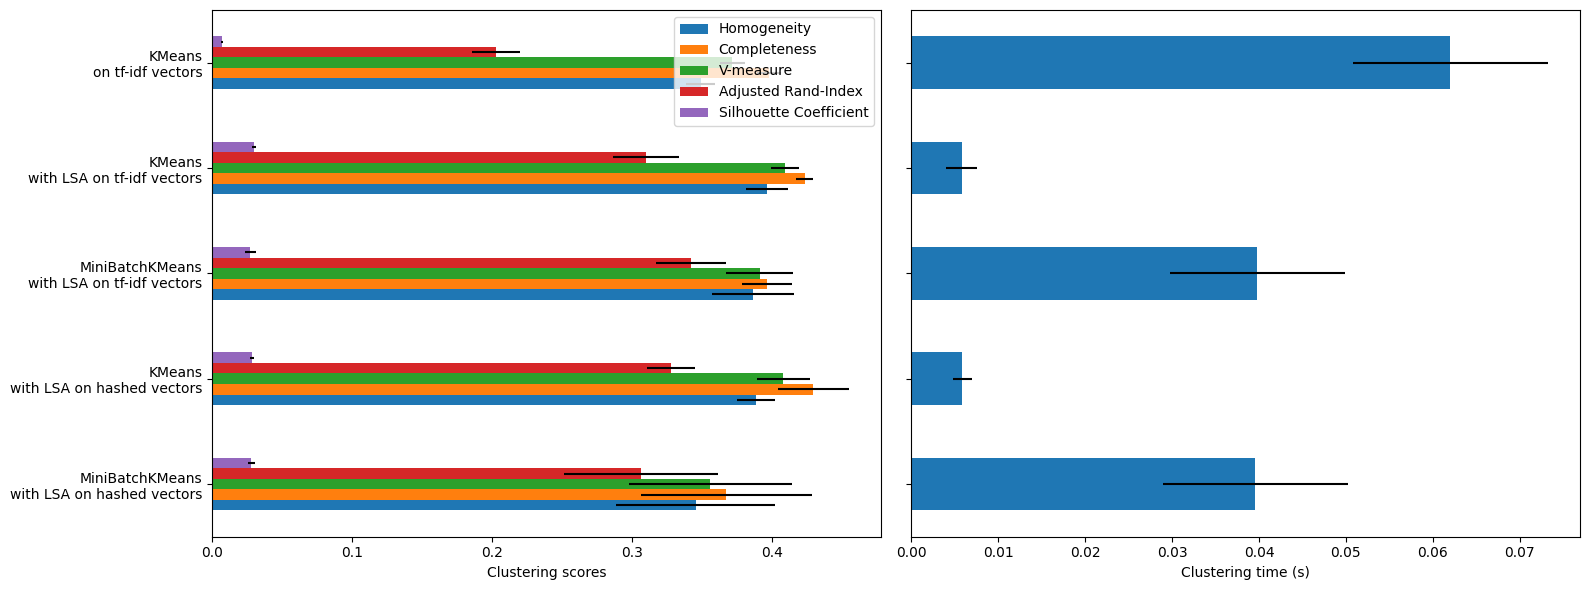

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()

Как видим, модель успешно справилась с заданием, а наиболее эффективным оказался K-means с использованием LSA на хэшированных векторах